<a href="https://colab.research.google.com/github/FedericaBellini22/CVProject-2024/blob/main/parking_occupancy_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Extract the tar.gz file
!tar -xvzf '/content/drive/My Drive/PKLot.tar.gz' -C /content/pklot/



Output streaming troncato alle ultime 5000 righe.
PKLot/PKLotSegmented/PUC/Sunny/2012-09-20/Occupied/2012-09-20_18_09_45#088.jpg
PKLot/PKLotSegmented/PUC/Cloudy/2012-09-28/Occupied/2012-09-28_09_06_05#086.jpg
PKLot/PKLotSegmented/PUC/Cloudy/2012-10-31/Occupied/2012-10-31_14_33_21#092.jpg
PKLot/PKLotSegmented/UFPR04/Rainy/2013-01-21/Occupied/2013-01-21_08_35_04#011.jpg
PKLot/PKLotSegmented/PUC/Cloudy/2012-10-16/Empty/2012-10-16_06_26_44#050.jpg
PKLot/PKLotSegmented/PUC/Cloudy/2012-09-28/Occupied/2012-09-28_11_06_11#047.jpg
PKLot/PKLotSegmented/PUC/Sunny/2012-09-17/Occupied/2012-09-17_10_59_02#100.jpg
PKLot/PKLotSegmented/UFPR05/Sunny/2013-03-10/Empty/2013-03-10_17_35_13#027.jpg
PKLot/PKLotSegmented/PUC/Sunny/2012-10-27/Empty/2012-10-27_12_15_53#018.jpg
PKLot/PKLotSegmented/PUC/Rainy/2012-09-21/Occupied/2012-09-21_11_45_24#077.jpg
PKLot/PKLotSegmented/PUC/Sunny/2012-09-20/Occupied/2012-09-20_17_34_43#052.jpg
PKLot/PKLotSegmented/UFPR05/Cloudy/2013-03-17/Empty/2013-03-17_15_20_10#033.jpg


In [4]:
# Check the extracted files
!ls /content/pklot/

PKLot


In [5]:
import os
import shutil
import random

# Define the base dataset directory
dataset_base_dir = '/content/pklot/PKLot/'  # The main directory after unzipping
segmented_base_dir = '/content/pklot/PKLotSegmented/'  # Include the segmented images if needed

# Define directories for organized dataset
train_dir = '/content/pklot/train'
val_dir = '/content/pklot/validation'
test_dir = '/content/pklot/test'

# Create directories for train, validation, and test sets
for directory in [train_dir, val_dir, test_dir]:
    for label in ['empty', 'occupied']:
        os.makedirs(os.path.join(directory, label), exist_ok=True)

# Split ratios
train_split = 0.7
val_split = 0.2
test_split = 0.1

# Collect image paths from all subdirectories
image_paths = []

# Walk through all directories under PKLot and PKLotSegmented
for base_dir in [dataset_base_dir, segmented_base_dir]:
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.jpg'):
                image_paths.append(os.path.join(root, file))

# Shuffle the image paths to ensure random distribution
random.shuffle(image_paths)

# Function to move files based on the labels
def move_images(image_paths, start_idx, end_idx, dest_dir):
    for img_path in image_paths[start_idx:end_idx]:
        if 'Empty' in img_path or 'empty' in img_path:  # Assuming filenames or directories indicate label
            shutil.move(img_path, os.path.join(dest_dir, 'empty', os.path.basename(img_path)))
        elif 'Occupied' in img_path or 'occupied' in img_path:
            shutil.move(img_path, os.path.join(dest_dir, 'occupied', os.path.basename(img_path)))

# Calculate the indices for splitting the dataset
total_images = len(image_paths)
train_idx = int(train_split * total_images)
val_idx = int((train_split + val_split) * total_images)

# Move images to the corresponding train, validation, and test directories
move_images(image_paths, 0, train_idx, train_dir)
move_images(image_paths, train_idx, val_idx, val_dir)
move_images(image_paths, val_idx, total_images, test_dir)

print(f"Total images: {total_images}")
print(f"Training set: {train_idx} images")
print(f"Validation set: {val_idx - train_idx} images")
print(f"Test set: {total_images - val_idx} images")


Total images: 708268
Training set: 495787 images
Validation set: 141654 images
Test set: 70827 images


In [6]:
import tensorflow as tf

IMG_HEIGHT = 128  # Adjust based on your model input size
IMG_WIDTH = 128   # Adjust based on your model input size
BATCH_SIZE = 32

# Load the training dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/pklot/train',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='binary'  # Assuming binary classification: empty vs occupied
)

# Load the validation dataset
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/pklot/validation',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

# Load the test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/pklot/test',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)


Found 487085 files belonging to 2 classes.
Found 139140 files belonging to 2 classes.
Found 69626 files belonging to 2 classes.


In [7]:
from tensorflow.keras import layers, models

# Define the CNN model
def build_cnn_model():
    model = models.Sequential([
        layers.InputLayer(input_shape=(128, 128, 3)),  # Adjust the input shape based on your image size
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Binary classification: empty vs occupied
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Build the model
model = build_cnn_model()

# Summary of the model architecture
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train the model for 10 epochs (adjust the number of epochs if needed)
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

Epoch 1/10
15222/15222 ━━━━━━━━━━━━━━━━━━━━ 406s 26ms/step - accuracy: 0.9792 - loss: 0.6224 - val_accuracy: 0.9952 - val_loss: 0.0166
Epoch 2/10
15222/15222 ━━━━━━━━━━━━━━━━━━━━ 345s 20ms/step - accuracy: 0.9954 - loss: 0.0184 - val_accuracy: 0.9973 - val_loss: 0.0112
Epoch 3/10
15222/15222 ━━━━━━━━━━━━━━━━━━━━ 320s 20ms/step - accuracy: 0.9945 - loss: 0.0268 - val_accuracy: 0.9966 - val_loss: 0.0145
Epoch 4/10
15222/15222 ━━━━━━━━━━━━━━━━━━━━ 360s 23ms/step - accuracy: 0.9966 - loss: 0.0163 - val_accuracy: 0.9974 - val_loss: 0.0141
Epoch 5/10
15222/15222 ━━━━━━━━━━━━━━━━━━━━ 338s 22ms/step - accuracy: 0.9974 - loss: 0.0118 - val_accuracy: 0.9981 - val_loss: 0.0094
Epoch 6/10
15222/15222 ━━━━━━━━━━━━━━━━━━━━ 346s 20ms/step - accuracy: 0.9980 - loss: 0.0095 - val_accuracy: 0.9984 - val_loss: 0.0085
Epoch 7/10
15222/15222 ━━━━━━━━━━━━━━━━━━━━ 357s 22ms/step - accuracy: 0.9983 - loss: 0.0085 - val_accuracy: 0.9980 - val_loss: 0.0099
Epoch 8/10
15222/15222 ━━━━━━━━━━━━━━━━━━━━ 341s 20ms/s

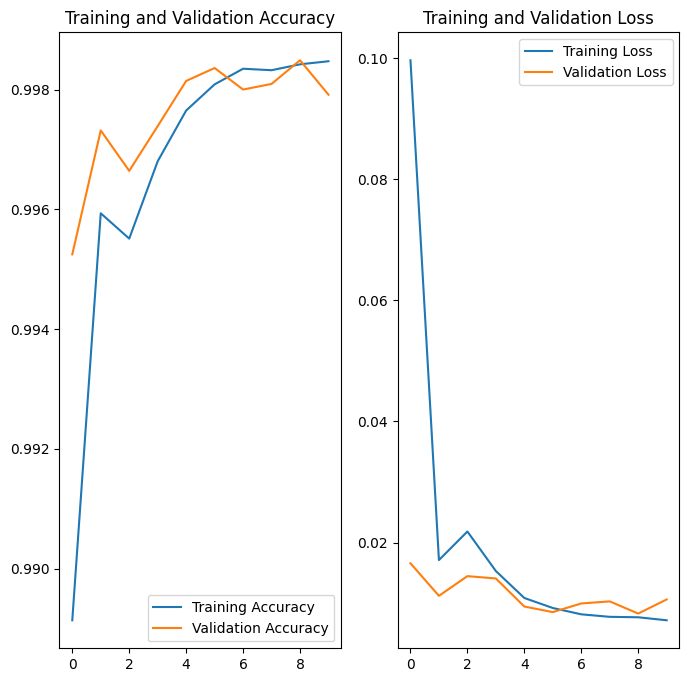

In [9]:
import matplotlib.pyplot as plt

# Plot accuracy and loss over epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# Accuracy plot
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [10]:
# Evaluate the model on the test dataset
results = model.evaluate(test_dataset)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

2176/2176 ━━━━━━━━━━━━━━━━━━━━ 33s 15ms/step - accuracy: 0.9976 - loss: 0.0134
Test Loss: 0.015450057573616505, Test Accuracy: 0.9975009560585022
